In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicide-watch/Suicide_Detection.csv



## 🧠Introduction

In this notebook, I explore the **Suicide Detection dataset** using Natural Language Processing (NLP) techniques. 
The goal is to build a reliable text classification model that can distinguish between **suicidal** and **non‑suicidal** 
expressions with high accuracy.

To achieve this, I followed a clear and structured workflow:

- **Importing Libraries** – loading essential Python packages for data handling, visualization, and modeling.  
- **Data Exploration** – examining the dataset, understanding its structure, and identifying patterns in text and labels.  
- **Data Analysis** – visualizing distributions, text lengths, and frequent words to gain deeper insights.  
- **Modeling & Evaluation** – training multiple machine learning models (TF‑IDF + LinearSVM, Logistic Regression, etc.), 
  comparing their performance, and selecting the best.  
- **Save Model** – exporting the final model for deployment in a web application.  


## Importing Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score,confusion_matrix

## Data Exploration

In [3]:
data=pd.read_csv("/kaggle/input/suicide-watch/Suicide_Detection.csv")

In [4]:
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
data.shape

(232074, 3)

In [6]:
data = data.rename(columns={"text": "text", "class": "label"})
data = data[["text", "label"]].dropna()

In [7]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [8]:
print(data.label.value_counts())

label
suicide        116037
non-suicide    116037
Name: count, dtype: int64


In [9]:
# Remove exact duplicates
data = data.drop_duplicates(subset=["text"])

# Strip whitespace
data["text"] = data["text"].str.strip()

## Data Analysis

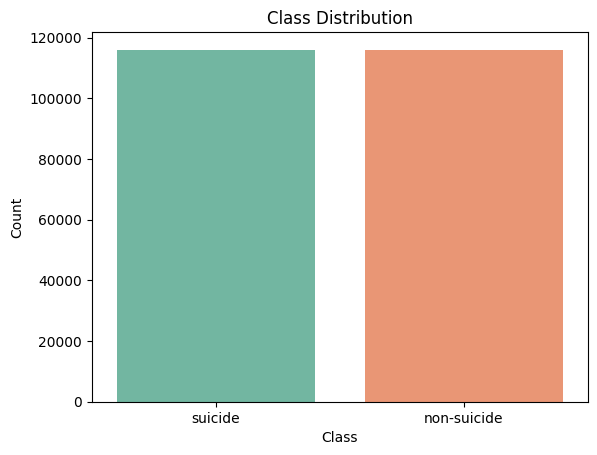

In [10]:
sns.countplot(x="label", data=data, palette="Set2")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

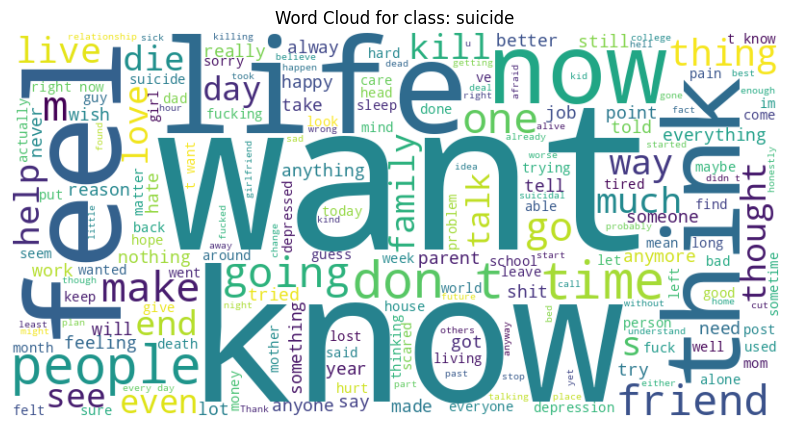

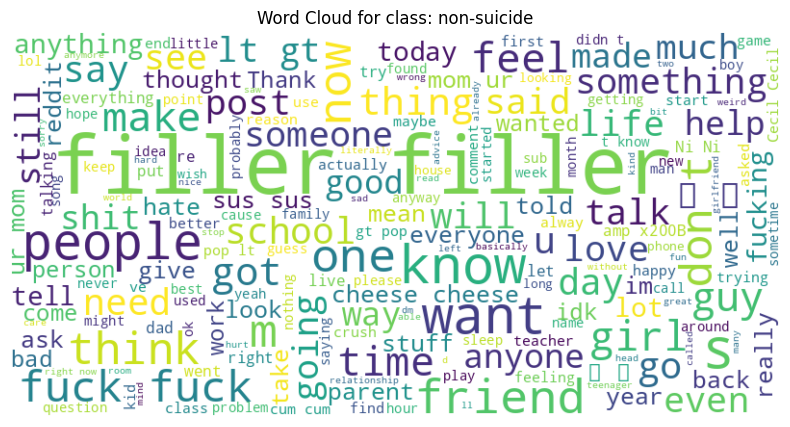

In [11]:
from wordcloud import WordCloud

for label in data["label"].unique():
    text_data = " ".join(data[data["label"] == label]["text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_data)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for class: {label}")
    plt.show()

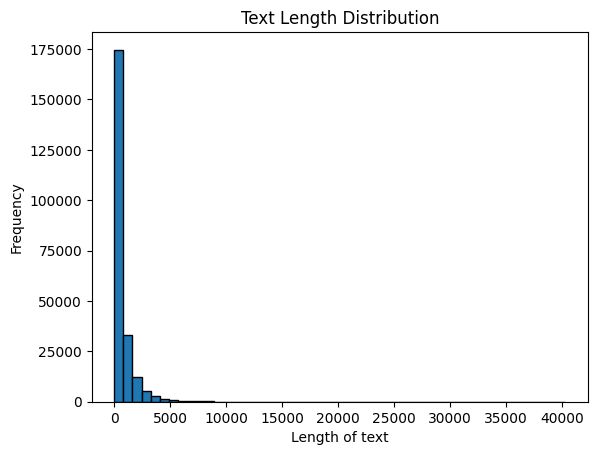

In [12]:
data["text_length"] = data["text"].str.len()
plt.hist(data["text_length"], bins=50, edgecolor="black")
plt.title("Text Length Distribution")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

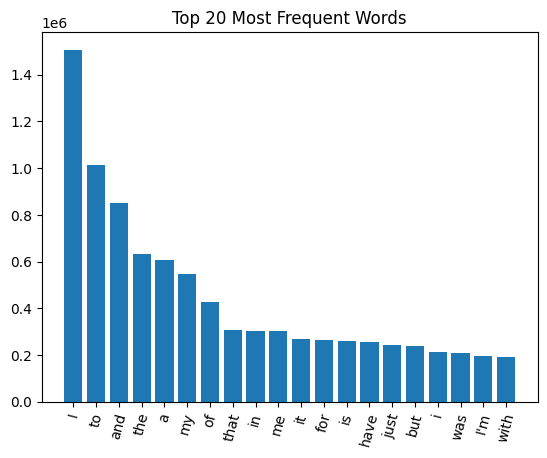

In [13]:
from collections import Counter
all_words = " ".join(data["text"]).split()
counter = Counter(all_words)
common_words = counter.most_common(20)

words, counts = zip(*common_words)
plt.bar(words, counts)
plt.xticks(rotation=75)
plt.title("Top 20 Most Frequent Words")
plt.show()

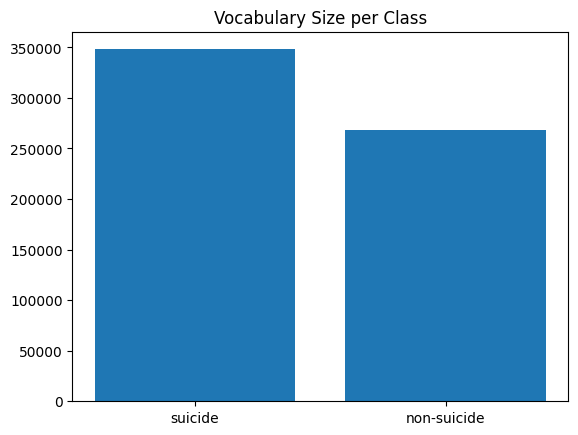

In [14]:
vocab_per_class = {
    label: len(set(" ".join(data[data["label"]==label]["text"]).split()))
    for label in data["label"].unique()
}
plt.bar(vocab_per_class.keys(), vocab_per_class.values())
plt.title("Vocabulary Size per Class")
plt.show()

## Modeling & Evaluation

In [15]:
train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data["label"]
)

print(train_df.label.value_counts(normalize=True))
print(test_df.label.value_counts(normalize=True))

label
suicide        0.500003
non-suicide    0.499997
Name: proportion, dtype: float64
label
non-suicide    0.500011
suicide        0.499989
Name: proportion, dtype: float64


In [16]:
def evaluate(y_true, y_pred, title=""):
    print(title)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Macro F1:", f1_score(y_true, y_pred, average="macro"))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Set2")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

TF-IDF + LinearSVM
Accuracy: 0.9509641279758698
Macro F1: 0.9509631714132905
              precision    recall  f1-score   support

 non-suicide       0.95      0.96      0.95     23208
     suicide       0.95      0.95      0.95     23207

    accuracy                           0.95     46415
   macro avg       0.95      0.95      0.95     46415
weighted avg       0.95      0.95      0.95     46415



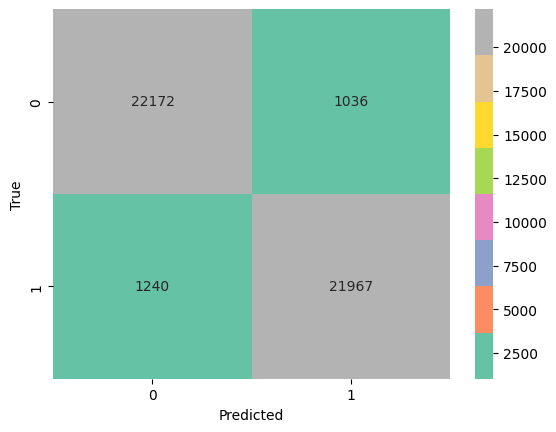

In [17]:
tfidf_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),       
        min_df=2,                 # ignore rare tokens
        max_df=0.95,              # ignore overly common tokens
        sublinear_tf=True,        # log-scale term frequency
        strip_accents="unicode"   # normalize accents
    )),
    ("clf", LinearSVC(C=1.0))
])

tfidf_svm.fit(train_df.text, train_df.label)
pred_svm = tfidf_svm.predict(test_df.text)
evaluate(test_df.label, pred_svm, title="TF-IDF + LinearSVM")

TF-IDF + LogisticRegression
Accuracy: 0.9462027361844232
Macro F1: 0.9461996419459384
              precision    recall  f1-score   support

 non-suicide       0.94      0.95      0.95     23208
     suicide       0.95      0.94      0.95     23207

    accuracy                           0.95     46415
   macro avg       0.95      0.95      0.95     46415
weighted avg       0.95      0.95      0.95     46415



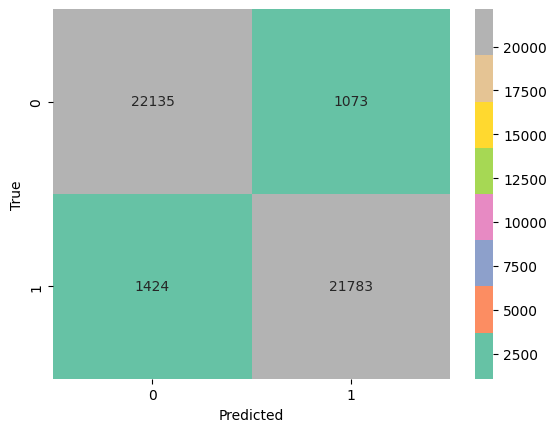

TF-IDF + MultinomialNB
Accuracy: 0.8615318323817731
Macro F1: 0.859279603969229
              precision    recall  f1-score   support

 non-suicide       0.98      0.74      0.84     23208
     suicide       0.79      0.99      0.88     23207

    accuracy                           0.86     46415
   macro avg       0.89      0.86      0.86     46415
weighted avg       0.89      0.86      0.86     46415



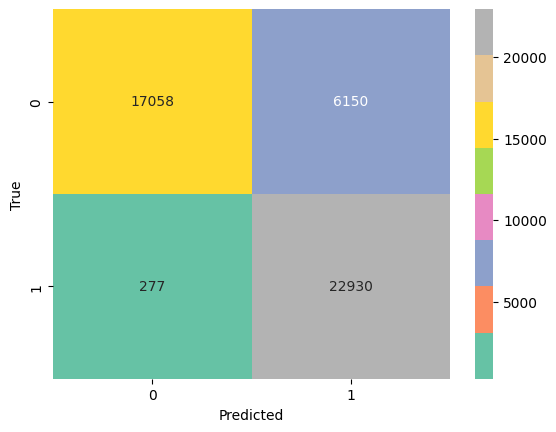

In [18]:
tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True, strip_accents="unicode")),
    ("clf", LogisticRegression(max_iter=3000, C=2.0, class_weight="balanced"))
])

tfidf_nb = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", MultinomialNB())
])

tfidf_lr.fit(train_df.text, train_df.label)
pred_lr = tfidf_lr.predict(test_df.text)
evaluate(test_df.label, pred_lr, title="TF-IDF + LogisticRegression")

tfidf_nb.fit(train_df.text, train_df.label)
pred_nb = tfidf_nb.predict(test_df.text)
evaluate(test_df.label, pred_nb, title="TF-IDF + MultinomialNB")

## Save Model

In [19]:
import joblib

# Save the pipeline (TF-IDF + LinearSVM)
joblib.dump(tfidf_svm, "tfidf_svm.pkl")
print("Model saved as tfidf_svm.pkl")

Model saved as tfidf_svm.pkl
